# IBM 推荐系统

在此 notebook 中，你将运用所学的推荐技能处理 IBM Watson Studio 平台的真实数据。 


你可以通过此 workspace 提交 notebook，或者在本地机器上操作并在下个页面提交 notebook。无论是哪种方式，都请确保代码符合项目[审阅标准](https://review.udacity.com/#!/rubrics/2632/view)。**请定期保存代码。**

跟着目录操作，你将能够创建多个不同的推荐方法，这些方法可以用于不同的情形。 


## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV.[基于内容的推荐方法（选修内容）](#Content-Recs)<br>
V. [矩阵分解](#Matrix-Fact)<br>
VI.[其他内容和总结](#conclusions)

首先导入必要的库并读取数据。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import random

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.article_id = df.article_id.astype(str)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


- From above numbers, we could see that one article may relate to multiple emails, which means that **emails represent user accounts**.

In [4]:
# Show df_content to get an idea of the data
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [5]:
len(df_content.article_id.unique())

1051

In [6]:
## modify df_content to all lower letters. Find exceptional ones and print the row numbers.
error_rows = list()
for i in range(len(df_content)):
    if type(df_content.doc_description[i])==type('a'):
        df_content.loc[df_content.index[i],'doc_description'] = df_content.doc_description[i].lower()
    else:
        error_rows.append(i)

### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>

通过以下字典和单元格了解数据的描述性统计信息。

`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

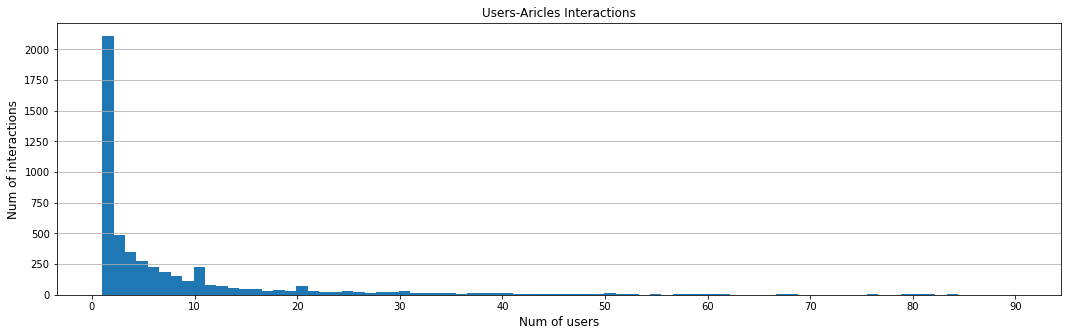

In [7]:
# Find the interactions of User-Article.

usr_article_interactions = df.email.value_counts()

fig,ax = plt.subplots(figsize = (18,5))
ax.set_xticks(np.arange(0,100,10));
ax.grid(which = 'major', axis = 'y')
ax.set_title('Users-Aricles Interactions')

plt.xlabel('Num of users', fontsize = 12)
plt.ylabel('Num of interactions', fontsize =12 )

ax.hist(usr_article_interactions, bins = 80, range = (1,90));

In [8]:
usr_article_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby(['email']).article_id.count().median()  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(['email']).article_id.count().max() # The maximum number of user-article interactions by any 1 user is ______.

`2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [10]:
# Find and explore duplicate articles
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id','first',inplace = True)

In [11]:
len(df_content.article_id.unique())

1051

In [12]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null int64
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


`3.` 在以下单元格中查找：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [13]:
len(df.article_id.unique())

714

In [14]:
len(df.email.unique())

5149

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [16]:
print(df.info())
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null int64
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


In [17]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` 在以下单元格中查找查看次数最多的文章的 **article_id**，以及被查看频率。在与公司领导讨论后，`email_mapper` 函数被视为将用户映射到 ID 的合理方式。有少数几个空值，并且所有这些空值都可能属于一个用户（我们以这种方式使用以下函数存储了这些值）。

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [19]:
#
df.groupby(['article_id']).email.count().max()

937

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [21]:
df.article_id.count()

45993

In [22]:
from collections import Counter
def counter(arr):
    return Counter(arr).most_common(2)

In [23]:
counter(df.article_id)

[('1429.0', 937), ('1330.0', 927)]

In [24]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [25]:
unique_users = len(df.email.unique())-1

In [26]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

与之前的课程不同，我们没有关于用户是否喜欢某篇文章的评分。我们只知道用户与文章互动了。在这些情形下，文章的热门程度只能通过**用户与文章的互动频率**来判断。

`1.` 填写以下函数，使其返回前 **n** 篇文章，按照互动次数从高到低排序。使用以下测试测试你的函数。

In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df[df.article_id.isin(get_top_article_ids(n,df))].title.unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    temp_df = df.groupby(['article_id']).user_id.count()
    temp_df2 =  temp_df.sort_values(axis = 0,ascending = False)
    top_articles = temp_df2[:n].index
    return top_articles # Return the top article ids

In [31]:
df.tail()

,article_id,title,user_id
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148
45992,16.0,higher-order logistic regression for large dat...,5149


In [32]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0'],
      dtype='object', name='article_id')


In [33]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


**Notes above**
- indexes should be adressed appropriately to get the right results.
- set_index is used to get quick results.

### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 使用以下函数调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。


* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 

使用以下测试检验矩阵的基本结构是否与解答中的结构一致。

In [34]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_items = df[['user_id','article_id']]
    user_items =  user_items.groupby(['user_id','article_id']).article_id.count().unstack()
    user_items.fillna(0, inplace=True) # substitute Na with 0.0
    # Change values in dataframe by col name.
    for col in user_items.columns:
        user_items[col] = np.where(user_items[col]>0,1,0)
    return user_items # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` 完成以下函数，该函数应该接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回的列表不应包含提供的 user_id，因为我们知道每个用户都与其本身相似。因为每个用户的结果是二元的，所以建议用两个用户的点积表示相似性。 

使用测试测试你的函数。

In [36]:
# compute similarity of each user to the provided user
def df_sim(user_id, user_item=user_item):
    sim_user = {'user_id':list(),'sim_score':list()}
    for i in user_item.index:
        new_sim = np.dot(user_item[user_item.index==user_id].values,user_item[user_item.index==i].values.T)
        sim_user['user_id'].append(i)
        sim_user['sim_score'].append(new_sim[0][0])  
    
    # sort by similarity
    df_sim = pd.DataFrame(sim_user)
    df_sim = df_sim.sort_values(by=['sim_score'], axis = 0, ascending = False)
    # remove user_id itself from the sorted values
    df_sim.drop(df_sim[df_sim['user_id']==user_id].index,inplace = True)
    df_sim = df_sim.reset_index()
    most_similar_users = df_sim['user_id']
    return df_sim

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - aa(pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    most_similar_users = df_sim(user_id,user_item=user_item)['user_id']

    return most_similar_users # return a list of the users in order from most to least similar
        

In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: 0    3933
1      23
2    3782
3     203
4    4459
5    3870
6     131
7    4201
8      46
9    5041
Name: user_id, dtype: int64
The 5 most similar users to user 3933 are: 0       1
1      23
2    3782
3     203
4    4459
Name: user_id, dtype: int64
The 3 most similar users to user 46 are: 0    4201
1    3782
2      23
Name: user_id, dtype: int64


`3.` 创建了为每个用户提供最相似用户的函数后，你需要使用这些用户查找可以推荐的文章。完成以下函数，以返回向每个用户推荐的文章。

In [38]:
# Note: to modify the type of article_id to str
df.article_id = df.article_id.astype('str')

In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list()
    for i in article_ids:
        article_names.append(df[df.article_id==i].title.unique()[0])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    ## 注意user_id 和 Index的关系！
    index_user = user_id -1
    article_ids = user_item.iloc[index_user][user_item.iloc[index_user]!=0].index.values
    article_names = get_article_names(article_ids,df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # compute user_id articles 找到user_id对应的 文章
    user_article_ids,user_article_names = get_user_articles(user_id) # here is example， where user_id = 1
    a = set(user_article_ids)  #用a 表示，避免变量太长而影响理解代码

    # initialization rec_article 初始化推荐集合 和 推荐个数
    set_rec = set() # store rec_art_ids in list.
    len_rec = 0 # store the len_rec

    # 找到喜好相似的用户id
    sim_users_id = find_similar_users(user_id)
    
    # 对每一个相似用户的文章中，提取推荐文章
    for i in sim_users_id:
        # find sim_user_art_ids
        sim_users_article_ids,sim_users_article_names = get_user_articles(i)
    
        # append rec_article 找到新增文章集合
        b = set(sim_users_article_ids)
        # 找到推荐集合
        new_rec_init = b.difference(set(a)) # b中有，a中没有的,未删除重复
   
        # Compare with pre-rec
        ## pre-rec
        len_pre = len(set_rec) #上次推荐集合长度
        rec_pre = set_rec #上次推荐集合
    
        ## 添加到原有推荐集合中
        this_set_rec = set(list(set_rec) + list(new_rec_init))
        len_this = len(this_set_rec) - len_pre # new added number of articles.新增文章数
        new_rec = this_set_rec.difference(rec_pre)      # 新增文章集
        
        ## update [rec_article_ids, a,] 
        set_rec = this_set_rec # 更新推荐集n (set_rec)
        len_rec = len(set_rec) # 更新推荐集长度

        # 查看推荐个数 是否>=m
        if len_rec == m:
            break
        
        ## 如果大于了m, 随机去掉>m的最后推荐的几个
        if len_rec > m:
            len_remove = len_rec-m #最后一次推荐个数 - 超出个数
            rand_index = random.sample(range(0,len(new_rec)),len_remove)
            rand_remove = [list(new_rec)[i] for i in range(0,len(list(new_rec))) if i in rand_index]
            final_set_rec = set_rec - set(rand_remove)
            break
            
    recs = final_set_rec
    return recs # return your recommendations for this user_id    

In [40]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['small steps to tensorflow',
 'maximize oil company profits',
 'deep learning from scratch i: computational graphs',
 'deep learning achievements over the past year ',
 'data tidying in data science experience',
 'spark 2.1 and job monitoring available in dsx',
 'why even a moth’s brain is smarter than an ai',
 'build a python app on the streaming analytics service',
 'optimizing a marketing campaign: moving from predictions to actions',
 'markdown for jupyter notebooks cheatsheet']

In [41]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。你可以利用之前编写的 **top_articles** 函数获得这种排名。

In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    df_similar = df_sim(user_id)
    df_similar['total_interact'] = ''
    
    # add TOTAL_INTERACT to df_sim
    for i in range(len(df_similar)):
        df_similar['total_interact'][i] = df.groupby('user_id').title.count()[df_similar.user_id[i]]
    
    df_similar = df_similar.sort_values(by = ['sim_score','total_interact'], ascending = False)
    df_similar.rename(columns = {'sim_score':'similarity','total_interact':'num_interactions','user_id':'neighbor_id'},inplace = True)
    df_similar.drop(['index'],axis=1,inplace = True)
    df_similar.reset_index(inplace = True)
    neighbors_df = df_similar
    
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # compute user_id articles 找到user_id对应的 文章
    user_article_ids,user_article_names = get_user_articles(user_id) # here is example， where user_id = 1
    a = set(user_article_ids)  #用a 表示，避免变量太长而影响理解代码

    # initialization rec_article 初始化推荐集合 和 推荐个数
    set_rec = set() # store rec_art_ids in list.
    len_rec = 0 # store the len_rec
    
    neighbors_list = get_top_sorted_users(user_id)['neighbor_id'] # Find Out 最相似用户的list
    sim_users_id = neighbors_list
    # 对每一个相似用户的文章中，提取推荐文章
    for i in sim_users_id:
        # find sim_user_art_ids
        sim_users_article_ids,sim_users_article_names = get_user_articles(i)
    
        # append rec_article 
        b = set(sim_users_article_ids)
        # 找到推荐集合
        new_rec_init = b.difference(a) # b中有，a中没有的,未删除重复
   
        # Compare with pre-rec
        ## pre-rec
        len_pre = len(set_rec) #上次推荐集合长度
        rec_pre = set_rec #上次推荐集合
    
        ## 添加到原有推荐集合中
        this_set_rec = set(list(set_rec) + list(new_rec_init))
        len_this = len(this_set_rec) - len_pre # new added number of articles.新增文章数
        new_rec = this_set_rec.difference(rec_pre)      # 新增文章集
        
        ## update [rec_article_ids, a,] 
        set_rec = this_set_rec # 更新推荐集n (set_rec)
        len_rec = len(set_rec) # 更新推荐集长度

        # 查看推荐个数 是否>=m
        if len_rec == m:
            break
        
        ## 如果大于了m, 按排好的顺序进行推荐
        if len_rec > m:
            len_to_rec = m - len_pre #最后一次应该推荐的个数
            article_ids_to_rec = list(new_rec)
            A = get_top_article_ids(len(df))
            B = article_ids_to_rec            
            B = [item for item in A if item in B]
            
            final_set_rec = rec_pre | set(B[:len_to_rec])
            break
            
    recs = final_set_rec
    rec_names = get_article_names(recs)
    return recs, rec_names

In [43]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

/Users/mialu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The top 10 recommendations for user 20 are the following article ids:
{'1364.0', '1170.0', '1160.0', '1368.0', '1351.0', '1304.0', '1354.0', '1427.0', '1162.0', '1330.0'}

The top 10 recommendations for user 20 are the following article names:
['predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze accident reports on amazon emr spark', 'putting a human face on machine learning', 'model bike sharing data with spss', 'gosales transactions for logistic regression model', 'movie recommender system with spark machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze energy consumption in buildings', 'insights from new york car accident reports']


`5.` 请利用上述函数正确填写以下字典。然后对照解答检验该字典。按照以下注释提供必要的代码。

In [44]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'][0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'][9]# Find the 10th most similar user to user 131

/Users/mialu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` 如果是新用户，你可以使用上述哪个函数做出推荐？请解释。你能想到更好的推荐方法吗？在以下单元格中解释向新用户做出推荐的更好方法。

**get_top_article()可以向新用户作出推荐，即按照文章排名进行推荐。基于文章内容向新用户推测风格多样的文章，可能是更好的推荐方法。**

`7.` 利用现有函数向以下新用户提供前 10 篇推荐文章。你可以对照我们的解答测试你的函数，确保在如何做出推荐方面与我们的想法一致。

In [46]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [47]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">第四部分：基于内容的推荐方法（选修内容）</a>

**略**

### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

在此部分，你将利用矩阵分解向 IBM Watson Studio 平台上的用户推荐文章。

`1.` 你在上述**第三部分**的**第一个问题**中已经创建了 **user_item** 矩阵。接下来的第一个问题需要你运行单元格，为**第五部分**的其他步骤做好准备。

In [48]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [49]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，你可以对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [50]:
# Perform SVD on the User-Item Matrix Here
u,s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**因为没有NaN，所以和课程中的步骤不一样。**

`3.` 如何确定潜在特征的数量？这个问题比较难。运行以下单元格后你会发现，随着潜在特征数量的增加，用户-项目矩阵中 1 和 0 值的预测错误率会降低。运行以下单元格，了解当潜在特征的数量增加时，准确率会如何提高。

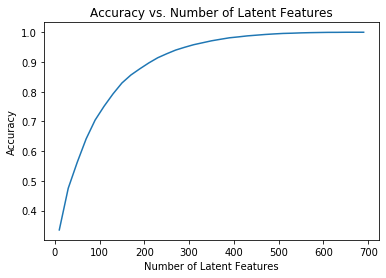

In [51]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

sum_errs_train = sum_errs

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。我们可以将数据集划分为训练集和测试集，如以下单元格所示。  

根据第三个问题的代码判断，不同的潜在特征数量对训练集和测试集的准确率有何影响。使用以下划分方法： 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [52]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx =  df_test['user_id'].unique()
    test_arts= df_test['article_id'].unique()

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [53]:
user_item_train

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4484,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Replace the values in the dictionary below
a = len([i for i in test_idx if i not in user_item_train.index]) 
b = len([i for i in test_arts if i in user_item_train.columns]) 
c = len([i for i in test_idx if i in user_item_train.index])
d = len([i for i in test_arts if i not in user_item_train.columns])  


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a,
    'How many movies can we make predictions for in the test set?':b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` 现在对上述 **user_item_train** 数据集进行奇异值分解，并得出 U、S 和 V 转置矩阵。然后判断在使用不同的潜在特征数量时，可以使用此矩阵分解方法对 **user_item_test** 数据集中的多少行做出预测，并根据测试数据的准确率确定应该保留多少个潜在特征。这个问题需要运用在第 `2` - `4`.个问题中完成的步骤。

通过以下单元格了解 SVD 在测试数据上做出推荐预测的效果如何。

In [55]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [56]:
a,b=[1,2,3,4,5],[2,3,4,5,6,7,8,9]
[i for i in a if i in b]

[2, 3, 4, 5]

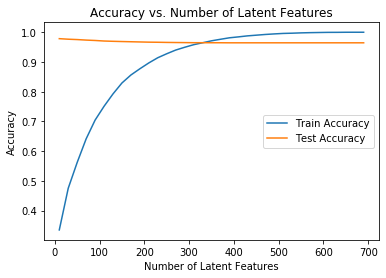

In [57]:
## run Prediction这里是需要的代码

# 初始化 features个数
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

# 利用train data来得到 s,u,vt
s,u,vt = s_train,u_train,vt_train
        
#找到被预测的test的子集 
test_idx_pred = [i for i in test_idx if i in user_item_train.index]
user_item_test_predicted = user_item_test.loc[test_idx_pred,test_arts] 

#进行预测
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product 得到user_item_est
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # 把user_item_est 转为dataFrame, 并附上index和column names.
    user_item_est = pd.DataFrame(user_item_est)
    user_item_est.columns=np.array(user_item_train.columns.values)
    user_item_est.index = np.array(user_item_train.index.values)
    
    test_idx_pred = [i for i in test_idx if i in user_item_est.index]

    # 得到预测的df       
    user_item_test_pred = user_item_est.loc[test_idx_pred,test_arts] 
    
    diffs = np.subtract(user_item_test_predicted, user_item_test_pred)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    # 计算共预测的个数
    total_pred = user_item_test_pred.shape[0]*user_item_test_pred.shape[1]
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0],label = 'Train Accuracy');
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/total_pred,label = 'Test Accuracy');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc='center right')

**可以对20行（用户）进行预测。从测试accuracy和训练accuracy的图中可以看出，需保留350以上的latent features,可使accuracy在90%以上。**

`6.` 在以下单元格中解释上个问题的结果。根据你得出的结果，讨论下你会如何判断上述推荐系统是否比用户目前查找文章的方式更好。 

**推荐预测在测试集上的运行效果很好，准确率在96%以上。**
- 可以进行A/B测试，来判断该推荐系统是否比用户目前查找文章的方式更好。
- 具体来讲，一部分用户使用原来的推荐系统，一部分用户使用新的推荐系统。设计一系列指标，比如用户阅读文章时间长度和篇数，用户上线时间等来评判哪个推荐系统更棒。
<a id='conclusions'></a>

In [58]:
# 储存文件
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM-zh.ipynb'])

0